In [1]:
import numpy as np
from scipy.ndimage import label, find_objects
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import SimpleITK as sitk
import pandas as pd
import radiomics
from radiomics import featureextractor
import os

def count_blob_pixels(array):
    # Label the blobs in the array
    labeled_array, num_features = label(array)

    # Calculate the number of pixels in each blob
    blob_sizes = [(labeled_array == i).sum() for i in range(1, num_features + 1)]

    return blob_sizes


def remove_small_blobs(array, min_size=100):
    # Label the blobs in the array
    labeled_array, num_features = label(array)

    # Find the sizes of each blob
    blob_sizes = [(labeled_array == i + 1).sum() for i in range(num_features)]

    # Create a mask to keep blobs that meet the size requirement or if it's the only blob
    if num_features == 1:
        mask = labeled_array != 0  # Keep the single blob regardless of size
    else:
        mask = np.isin(
            labeled_array,
            [i + 1 for i, size in enumerate(blob_sizes) if size >= min_size],
        )

    # Apply the mask to the original array
    filtered_array = array * mask

    return filtered_array


def extract_radiomics_features(pet_img, mask_array, output_dir, sub_name, label_type):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    mask_array = remove_small_blobs(mask_array)
    # Label the blobs in the array
    labeled_array, num_features = label(mask_array)

    # Initialize the PyRadiomics feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor()

    for i in range(1, num_features + 1):
        # Create the filename

        filename = f"{sub_name}_blob_{i}_label_{label_type}.csv"

        if Path(os.path.join(output_dir, filename)).exists():
            continue
        blob_mask = (labeled_array == i).astype(np.uint8)
        if blob_mask.sum()<=50:
            continue
        # Ensure the blob mask has the same shape as the original array
        assert blob_mask.shape == mask_array.shape
        mask_img = sitk.GetImageFromArray(blob_mask)
        mask_img.CopyInformation(pet_img)
        # Extract features
        feature_vector = extractor.execute(pet_img, mask_img)
        print(len(feature_vector))
        # Convert the feature vector to a pandas DataFrame
        feature_df = pd.DataFrame([feature_vector])

        # Remove non-numeric columns
        feature_df = feature_df.select_dtypes(include=[np.number])

        # Save the DataFrame as a CSV file
        feature_df.to_csv(os.path.join(output_dir, filename), index=False)


def calculate_tp_fp_fn(gt, pred):
    # Label the blobs
    gt_labels, num_gt = label(gt)
    pred_labels, num_pred = label(pred)

    # Find bounding boxes of blobs
    gt_slices = find_objects(gt_labels)
    pred_slices = find_objects(pred_labels)

    # Create empty masks for TP, FP, FN
    tp_mask = np.zeros_like(gt)
    fp_mask = np.zeros_like(gt)
    fn_mask = np.zeros_like(gt)

    # Calculate TP, FP, FN
    tp, fp, fn = 0, 0, 0

    # Helper function to determine if two blobs overlap
    def overlap(slice1, slice2):
        return not (
            slice1[0].stop < slice2[0].start
            or slice1[0].start > slice2[0].stop
            or slice1[1].stop < slice2[1].start
            or slice1[1].start > slice2[1].stop
            or slice1[2].stop < slice2[2].start
            or slice1[2].start > slice2[2].stop
        )

    matched_gt = set()
    matched_pred = set()

    for i, gt_slice in enumerate(gt_slices):
        gt_blob = gt_labels == (i + 1)
        match_found = False
        for j, pred_slice in enumerate(pred_slices):
            if overlap(gt_slice, pred_slice):
                pred_blob = pred_labels == (j + 1)
                tp_mask[gt_blob & pred_blob] = 1  # True positive overlap region
                tp += 1
                matched_gt.add(i)
                matched_pred.add(j)
                match_found = True
                break
        if not match_found:
            fn_mask[gt_blob] = 1

    for j, pred_slice in enumerate(pred_slices):
        if j not in matched_pred:
            pred_blob = pred_labels == (j + 1)
            fp_mask[pred_blob] = 1

    fn = num_gt - tp
    fp = num_pred - tp

    return tp_mask, fp_mask, fn_mask, tp, fp, fn


src_dir = Path("/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/")
pred_dir = "imagesTr_pred_res"
gt_dir = "imagesTr"
metrics=[]
for pred in tqdm((src_dir/pred_dir).glob("*.nii.gz")):
    fname = (pred.name).split(".nii")[0]
    gt = str(pred).replace("imagesTr_pred_res", "labelsTr")
    pred_array = sitk.GetArrayFromImage(sitk.ReadImage(pred))
    pet_img = (sitk.ReadImage(
        src_dir / "imagesTr" / str(fname + "_0000.nii.gz")
    ))
    gt_array = sitk.GetArrayFromImage(sitk.ReadImage(gt))
    gt_array = gt_array==20
    pred_array = pred_array==20
    tp_mask, fp_mask, fn_mask, tp, fp, fn = calculate_tp_fp_fn(gt_array, pred_array)
    fp_voxels = count_blob_pixels(fp_mask)
    fn_voxels = count_blob_pixels(fn_mask)
    tp_voxels = count_blob_pixels(tp_mask)
    radiomics_path = "tp_fp_fn_radiomics_ct"
    extract_radiomics_features(pet_img, fp_mask, radiomics_path, fname, "fp")
    extract_radiomics_features(pet_img, tp_mask, radiomics_path, fname, "tp")
    extract_radiomics_features(pet_img, fn_mask, radiomics_path, fname, "fn")
    metrics.append({"Subject": pred.name, "TP":tp, "FP": fp, "FN": fn, "TP_voxels": tp_voxels, "FP_voxels": fp_voxels, "FN_voxels": fn_voxels})
df = pd.DataFrame(metrics)
df.head()
df.to_csv("TP_FP_FN_res_model.csv")

0it [00:00, ?it/s]

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


129


In [2]:
import glob
def load_and_label_radiomics_data(folder_path, num_files=1000):
    # Get the list of tp and fp files
    tp_files = glob.glob(os.path.join(folder_path, "*_tp.csv"))[:num_files]
    fp_files = glob.glob(os.path.join(folder_path, "*_fp.csv"))[:num_files]

    # Load tp files into a DataFrame and add the label column
    tp_dataframes = []
    for file in tp_files:
        df = pd.read_csv(file)
        df["label"] = 1
        tp_dataframes.append(df)

    # Load fp files into a DataFrame and add the label column
    fp_dataframes = []
    for file in fp_files:
        df = pd.read_csv(file)
        df["label"] = 0
        fp_dataframes.append(df)

    # Concatenate all DataFrames
    all_data = pd.concat(tp_dataframes + fp_dataframes, ignore_index=True)

    return all_data


# Example usage
# folder_path = "tp_fp_fn_radiomics"
combined_data = load_and_label_radiomics_data(radiomics_path, num_files=1000)
print(combined_data.head())
print(len(combined_data))

   diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                      -908.964342                        -1368.807739   
1                      -912.161126                        -1457.807739   
2                      -881.026459                        -1598.900391   
3                      -957.705830                        -1313.069824   
4                      -919.534544                        -1437.792358   

   diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                         3265.816895                                 138   
1                         3243.423096                                 570   
2                         3737.096680                                 724   
3                         3330.528320                                 189   
4                         3217.746582                                 115   

   diagnostics_Mask-original_VolumeNum  original_shape_Elongation  \
0                      

In [6]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

def classify(cdf):
    y = cdf["label"]
    X = cdf.drop(columns=["label"])

    # Replace NaN values with the median of each column
    X = X.fillna(X.median())

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Step 2: Feature selection

    # Remove features with low variance
    selector = VarianceThreshold(threshold=0.01)
    X = selector.fit_transform(X)

    # Remove correlated features
    def remove_correlated_features(data, threshold=0.9):
        corr_matrix = pd.DataFrame(data).corr().abs()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)
        )
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        return pd.DataFrame(data).drop(columns=to_drop, axis=1).values

    X = remove_correlated_features(X)

    # Step 3: Run Extremely Randomized Trees (ExtraTreesClassifier)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    # Step 4: Predict probabilities and adjust threshold
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Define a custom threshold to maximize accuracy for negatives
    custom_threshold = 0.1  # Adjust this threshold as needed

    y_pred = (y_pred_proba >= custom_threshold).astype(int)

    # Step 5: Evaluate the model
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    # Get feature importances and indices of top features
    importances = clf.feature_importances_
    print(importances)
classify(combined_data)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.05      0.09       201
           1       0.51      0.98      0.67       199

    accuracy                           0.51       400
   macro avg       0.61      0.51      0.38       400
weighted avg       0.61      0.51      0.38       400

Accuracy: 0.51
Confusion Matrix:
[[ 10 191]
 [  4 195]]
[0.10261634 0.09822058 0.1035442  0.12292938 0.12439349 0.12003546
 0.11487313 0.10595383 0.10743359]


True Positives (TP): 1
False Positives (FP): 0
False Negatives (FN): 2


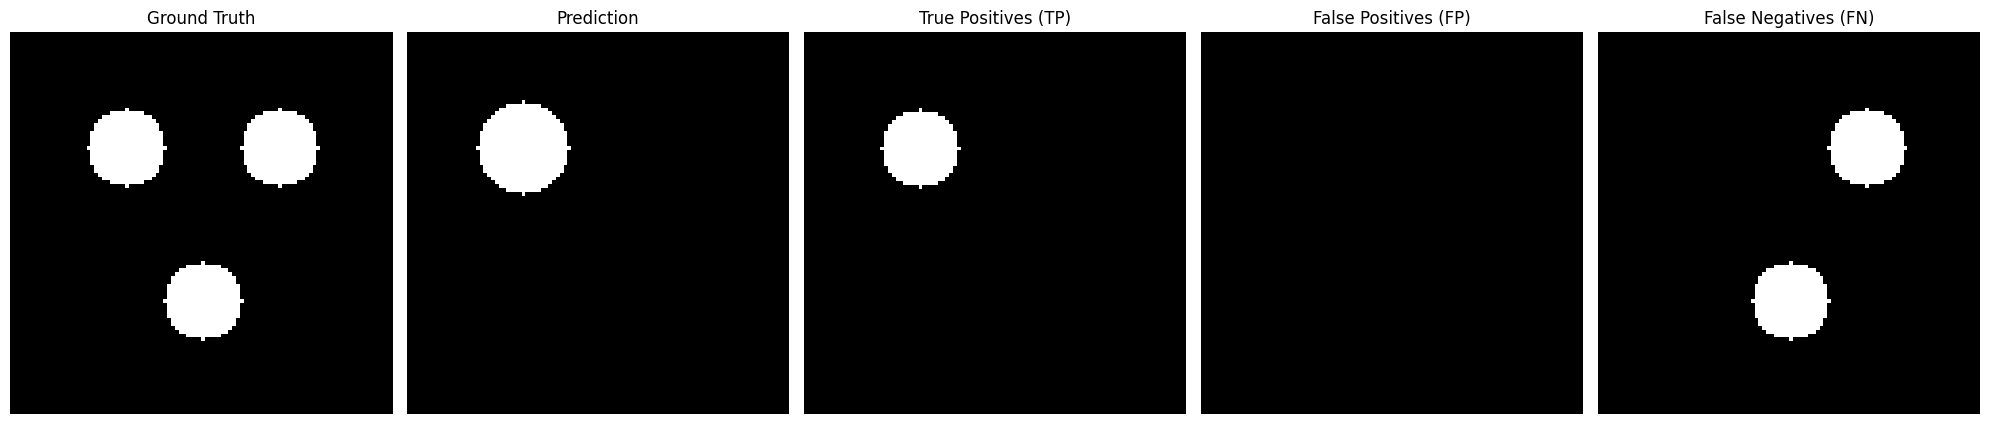

In [4]:
import cv2
import numpy as np
from scipy.ndimage import label, find_objects
import matplotlib.pyplot as plt

# Example ground truth and prediction arrays
gt = np.zeros((100, 100), dtype=np.uint8)
pred = np.zeros((100, 100), dtype=np.uint8)

# Create three blobs in the ground truth
cv2.circle(gt, (30, 30), 10, 255, -1)
cv2.circle(gt, (70, 30), 10, 255, -1)
cv2.circle(gt, (50, 70), 10, 255, -1)

# Create one blob in the prediction
cv2.circle(pred, (30, 30), 12, 255, -1)  # Slightly larger or smaller than GT

# Label the blobs
gt_labels, num_gt = label(gt)
pred_labels, num_pred = label(pred)

# Find bounding boxes of blobs
gt_slices = find_objects(gt_labels)
pred_slices = find_objects(pred_labels)

# Create empty masks for TP, FP, FN
tp_mask = np.zeros_like(gt)
fp_mask = np.zeros_like(gt)
fn_mask = np.zeros_like(gt)

# Calculate TP, FP, FN
tp, fp, fn = 0, 0, 0


# Helper function to determine if two blobs overlap
def overlap(slice1, slice2):
    return not (
        slice1[0].stop < slice2[0].start
        or slice1[0].start > slice2[0].stop
        or slice1[1].stop < slice2[1].start
        or slice1[1].start > slice2[1].stop
    )


matched_gt = set()
matched_pred = set()

for i, gt_slice in enumerate(gt_slices):
    gt_blob = gt_labels == (i + 1)
    match_found = False
    for j, pred_slice in enumerate(pred_slices):
        if overlap(gt_slice, pred_slice):
            pred_blob = pred_labels == (j + 1)
            tp_mask[gt_blob & pred_blob] = 255  # True positive overlap region
            tp += 1
            matched_gt.add(i)
            matched_pred.add(j)
            match_found = True
            break
    if not match_found:
        fn_mask[gt_blob] = 255

for j, pred_slice in enumerate(pred_slices):
    if j not in matched_pred:
        pred_blob = pred_labels == (j + 1)
        fp_mask[pred_blob] = 255

fn = num_gt - tp
fp = num_pred - tp

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].imshow(gt, cmap="gray")
axes[0].set_title("Ground Truth")

axes[1].imshow(pred, cmap="gray")
axes[1].set_title("Prediction")

axes[2].imshow(tp_mask, cmap="gray")
axes[2].set_title("True Positives (TP)")

axes[3].imshow(fp_mask, cmap="gray")
axes[3].set_title("False Positives (FP)")

axes[4].imshow(fn_mask, cmap="gray")
axes[4].set_title("False Negatives (FN)")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()